# Generating adversarial examples using Fast Gradient Sign Method
This notebook creates dataset of adversarial examples using the Fast Gradient Signed Method (FGSM) attack as described in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572) by Goodfellow et al. The network we are attacking is a CNN network constructed in **classifier_training.ipynb**.

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import matplotlib as mpl

Using TensorFlow backend.


In [2]:
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['axes.grid'] = False

### What is an adversarial example?
Adversarial examples are inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. Examples are created by modifying the original image by adding noise. Images modified in this way are unrecognizable to the human eye, but still cause the neural network to misclassify them.

There are several types of adversarial attacks, however, in this notebook the focus is on the **Fast Gradient Sign Method** attack, which is a white box attack. A white box attack is where the attacker has complete access to the model being attacked. In this particular case, we are intrested in gradient of our model's loss function with respect to the input image. More on this topic will be discussed later.

In [3]:
model = tf.keras.models.load_model('best_model')

In [4]:
def create_datagen():
    return ImageDataGenerator(
        rescale=1./255,
    )

def create_flow(datagen, directory):
    return datagen.flow_from_directory(
        directory = directory,
        target_size= (128, 128),
        color_mode = 'rgb',
        batch_size = 128,
        class_mode = 'categorical',
        shuffle = False
    )

In [5]:
def get_label_confidence(probs):
    labels = ['cat', 'dog', 'wild']
    idx = np.argmax(probs[0])
    return [labels[idx], probs[0][idx]]

def preprocess_image(image):
    image = tf.cast(image, tf.float32)
    image = image[None, ...]
    return image

In [15]:
dg = create_datagen()
gen = create_flow(dg, 'data/train')

Found 14630 images belonging to 3 classes.


### First adversarial example
Let's try to generate one adversarial image first. Later we will apply this approach to the whole dataset. To start, we need to pick a picture. Then we need to rescale it to the input shape of our model.

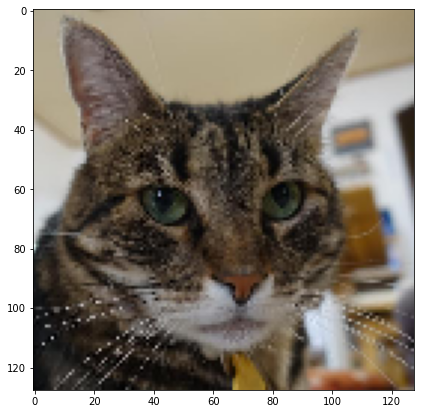

In [16]:
images, lab = gen.next()
# 16 is just random number
x = images[16]
y = lab[16]

plt.imshow(x)

In [8]:
x_reshaped = preprocess_image(x)
x_reshaped.shape

TensorShape([1, 128, 128, 3])

Let's see the predictions of our model for selected image. As we can see, the model is pretty confident (99.9%) that imput image is an image of cat.

In [9]:
probs = model(x_reshaped)
label, confidence = get_label_confidence(probs)
print('{} : {:.2f}% Confidence'.format( label, confidence*100))

cat : 99.98% Confidence


### Fast Gradient Sign Method
Now, let's construct a function that will take an image and its label and generate adversarial noise for this image.

The fast gradient sign method works by using the gradients of the neural network to create an adversarial example. For an input image, the method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. This can be summarised using the following expression:

$$adv\_x = x + \epsilon\cdot\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   $adv_x$ : Adversarial image.
*   $x$ : Original input image.
*   $y$ : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

In [10]:
def create_adversarial_pattern(input_image, input_label):
    input_image = preprocess_image(input_image)
    input_label = tf.reshape(input_label, (1, 3))
    
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = tf.keras.losses.CategoricalCrossentropy()(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

This is how the resulting noise looks like. In the next cells we can examine, how adding this noise to our original image affects predictions of our model.

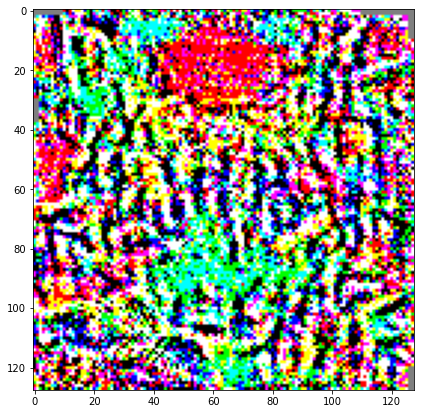

In [17]:
perturbations = create_adversarial_pattern(x, y)
# Rescale pixel values from [-1, 1] to [0,1]
plt.imshow(perturbations[0]*0.5+0.5)

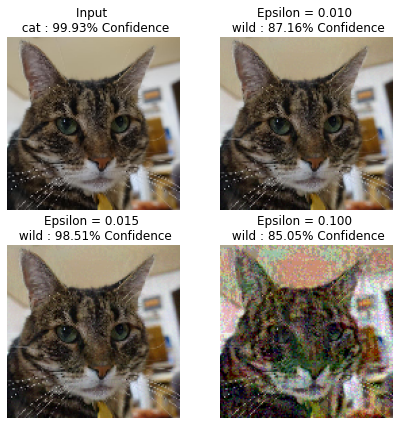

In [18]:
epsilons = [0, 0.01, 0.015, 0.1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

for i, eps in enumerate(epsilons):
    ax = plt.subplot(2, 2, i + 1)
    adv_x = x + eps*perturbations
    # our model was trained on images with pixel values in interval [0, 1]
    adv_x = tf.clip_by_value(adv_x, 0, 1)
    
    label, confidence = get_label_confidence(model(adv_x))

    plt.imshow(adv_x[0])     
    plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[i], label, confidence*100))
    plt.axis("off")

It's noticable that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable. For this reason we decided to only use epsilons 0.01, 0.015 and 0.1 (in the last case pertrubations are recognizable to the human eye, so it should be easier for the network to recognize them as attacks - we will try to confirm this in following notebooks).

### Creating whole dataset of adversarial examples
In this section we will repeat the process explained above for all samples from our train set to generate a dataset of adversarial examples. The main goal is to only include examples that fool the network, so we will not necessarily generate 3 new images for every image from the train set.

In [ ]:
eps_mapper = {
    0.01: "eps_small",
    0.015: "eps_medium",
    0.1: "eps_big"
}

label_mapper = {
    0: "cat",
    1: "dog",
    2: "wild"
}

cnt = 0

def map_values(eps, predicted_label, class_label):
    return eps_mapper[eps], label_mapper[predicted_label], label_mapper[class_label]

def convert_to_gen_idexes(number):
    batch_idx = number//128
    return [batch_idx, number - 128*batch_idx]

# sanity check
convert_to_gen_idexes(129)

In [ ]:
def save_adv_image(img, class_label, eps, predicted_label):
    global cnt
    cnt += 1
    tf.keras.preprocessing.image.save_img(
        'fgsm_attack/{}/{}/{}_{}.png'.format(*map_values(eps, predicted_label, class_label), cnt), 
        # perturbations[0]*0.5+0.5, 
        img[0],
        data_format=None, 
        file_format=None, 
        scale=True
    )

We will only generate attacks based on images that the network can classify **correctly**. As you can see from output of the second cell below, it is almost 97% of all images.

In [ ]:
# reset generator 
gen = create_flow(dg, 'data/train')

predictions = model.predict_generator(gen)
predictions_idx = [np.argmax(x) for x in predictions]

real_idx = gen.classes
correct_predictions = []

for i in range(len(predictions_idx)):
    if predictions_idx[i] == real_idx[i]:
        correct_predictions.append(i)

In [177]:
len(correct_predictions)

14145

For every image that was correctly classified we generate pertrubation using gradient of the network with respect to the image. Then we multiply the pertrubation with one of the 3 selected epsilons (0.01, 0.015, 0.1) and add it to the original image creating new image. We compute the prediction for the new image and determine whether or not it is incorrect. If it is, we have successfully created **adversarial example** and we can save it for later.  

In [ ]:
for idx in tqdm(correct_predictions):
    gen_idxs = convert_to_gen_idexes(idx)
    image = gen[gen_idxs[0]][0][gen_idxs[1]]
    label = gen[gen_idxs[0]][1][gen_idxs[1]]
    label_idx = np.argmax(label)
    
    perturbation = create_adversarial_pattern(image, label)
    epsilons = [0.01, 0.015, 0.1]
    for eps in epsilons:
        adv_img = image + eps*perturbation
        adv_img = tf.clip_by_value(adv_img, 0, 1)
    
        # get index of predicted label
        pred_idx = np.argmax(model(adv_img)[0])
        if pred_idx != label_idx:
            save_adv_image(adv_img, label_idx, eps, pred_idx)

We wanted to check that there was no bug in the code, so we fed the adversarial images to the model in attempt to verify, that it has misclassified them. Unfortunatelly this was not the case for all of the examples. It turned out that some pertrubations were so small that after saving and reloading they were rounded to such an extent that the resulting image was no longer an adversial attack. We can see it from output of the cells below. If everything worked correctly model's accuracy would be 100%. Small and medium values of epsilon retained the property of an adversarial attack in aproximately 50% of images. Big pertrubations are less likely to get rounded so much that the model classifies them correctly. We can verify this from 98% accuracy on eps_big data generator.

In [178]:
eps_small = create_flow(dg, 'fgsm_attack/eps_small')
eps_medium = create_flow(dg, 'fgsm_attack/eps_medium')
eps_big = create_flow(dg, 'fgsm_attack/eps_big')

Found 6101 images belonging to 3 classes.
Found 9668 images belonging to 3 classes.
Found 12932 images belonging to 3 classes.


In [179]:
model.evaluate(eps_small)

48/48 [==============================] - 18s 381ms/step - loss: 0.8862 - accuracy: 0.5311


[0.8862085429330667, 0.53106046]

In [180]:
model.evaluate(eps_medium)

76/76 [==============================] - 30s 397ms/step - loss: 0.9511 - accuracy: 0.5694


[0.9511001815921382, 0.56940424]

In [181]:
model.evaluate(eps_big)

102/102 [==============================] - 42s 408ms/step - loss: 0.0546 - accuracy: 0.9811


[0.05464913969155853, 0.9810547]

So what now? We could have saved the images in another format like .csv file, that supports floats as pixel values. But for the purposes of this semestral work, we decided to keep only the adversarial examples, that can survive saving and reloading.

In [ ]:
def get_files_to_delete(gen):
    predictions = model.predict_generator(gen)
    predictions_idx = [np.argmax(x) for x in predictions]
    
    real_idx = gen.classes
    filenames = gen.filenames
    
    drop_filenames = []
    for i in range(len(predictions_idx)):
        if predictions_idx[i] != real_idx[i]:
            drop_filenames.append(filenames[i])
            
    return drop_filenames

In [ ]:
to_drop_small = get_files_to_delete(eps_small)
to_drop_medium = get_files_to_delete(eps_medium)
to_drop_big = get_files_to_delete(eps_big)

In [ ]:
import os
path = '/Users/liz/school/MVI/adversarial_attacks/fgsm_attack/eps_small_reduced'
[os.remove(os.path.join(path,f)) for f in to_drop_small]

path = '/Users/liz/school/MVI/adversarial_attacks/fgsm_attack/eps_medium_reduced'
[os.remove(os.path.join(path,f)) for f in to_drop_medium]

path = '/Users/liz/school/MVI/adversarial_attacks/fgsm_attack/eps_big_reduced'
[os.remove(os.path.join(path,f)) for f in to_drop_big]

### Let's try it again!

In [183]:
eps_small_reduced = create_flow(dg, 'fgsm_attack/eps_small_reduced')
eps_medium_reduced = create_flow(dg, 'fgsm_attack/eps_medium_reduced')
eps_big_reduced = create_flow(dg, 'fgsm_attack/eps_big_reduced')

Found 3240 images belonging to 3 classes.
Found 5505 images belonging to 3 classes.
Found 12687 images belonging to 3 classes.


In [184]:
model.evaluate(eps_small_reduced)

26/26 [==============================] - 11s 408ms/step - loss: 0.2937 - accuracy: 1.0000


[0.293725892328299, 1.0]

In [185]:
model.evaluate(eps_medium_reduced)

44/44 [==============================] - 18s 410ms/step - loss: 0.2295 - accuracy: 1.0000


[0.22954241558909416, 1.0]

In [186]:
model.evaluate(eps_big_reduced)

100/100 [==============================] - 41s 414ms/step - loss: 0.0354 - accuracy: 1.0000


[0.035410753530304644, 1.0]

After deleting the images, which were too damaged by saving and reloading, we were left with only real adversarial examples in the dataset. For easier handling of the resulting dataset, we renamed the directories eps_<value>_reduced to eps_<value>. And that's it! In the following workbook, we will try to apply a different method of generating adversarial attacks - AT-GAN.